In [1]:
import numpy as np
import quaternion
import math
from numpy import linalg as LA
from math import *
from pyluos import Robot
import time

x0 = [1, 0, 0]
y0 = [0, 1, 0]
z0 = [0, 0, 1]

x0_quat = quaternion.quaternion(0,1,0,0)
y0_quat = quaternion.quaternion(0,0,1,0)
z0_quat = quaternion.quaternion(0,0,0,1)

Pc = [0,0,89.40]   #Coordinates of the plateform's center
C = [0,0,64.227]   #Coordinates of the center of the proximal circle
R = 39.162   #Radius of the distal circle
Rp = R*cos(40.0*pi/180)   #Radius of the proximal center

/Users/augustin/.virtualenvs/spherical-joint/lib/python3.6/site-packages/quaternion/numba_wrapper.py:20: UserWarning: 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Could not import from numba, which means that some
parts of this code may run MUCH more slowly.  You
may wish to install numba.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  warnings.warn(warning_text)


In [2]:
def my_atan2(y,x,beta):
    if beta>=0:
        if x<0:
            if (y/x)<=0:
                res = atan2(y,x)
            else:
                res = 2*pi+atan2(y,x)
        else:
            res = pi+atan2(y,x)

    else:
        if x<0:
            res = atan2(y,x)
        else:
            res = -2*pi+atan2(y,x)
    return res

In [3]:
def get_new_frame(vect,angle=0):

    beta = angle*math.pi/180


    ### GOAL VECTOR (the desired Z axis)###
    goal = vect


    goal_norm = []
    for i in goal:
        goal_norm.append(i/LA.norm(goal)) #Normalized vector of goal

    ### VECTOR AND ANGLE OF ROTATION ###
    vector= np.cross(z0,goal_norm)

    vector_norm = [] #Normalized vector of rotation
    for i in vector:
        vector_norm.append(i/LA.norm(vector))

    alpha = math.acos(np.vdot(z0,goal_norm)) #Angle of rotation

    if alpha == 0 :
        v = quaternion.quaternion(0.0,0.0,0.0,1.0)

    else :  
        v = quaternion.quaternion(0.0,vector_norm[0],vector_norm[1],vector_norm[2]) #Vector of rotation as a quaternion





    ### QUATERNION OF ROTATION ###
    w1 = math.cos(alpha/2.0)
    x1 = math.sin(alpha/2.0)*v.x
    y1 = math.sin(alpha/2.0)*v.y
    z1 = math.sin(alpha/2.0)*v.z

    q1 = quaternion.quaternion(w1,x1,y1,z1) #1st rotation quaternion
    q1_inv = q1.inverse()

    z_prime = q1*z0_quat*q1_inv

    w2 = math.cos(beta/2.0)
    x2 = math.sin(beta/2.0)*z_prime.x
    y2 = math.sin(beta/2.0)*z_prime.y
    z2 = math.sin(beta/2.0)*z_prime.z

    q2 = quaternion.quaternion(w2,x2,y2,z2) #Quaternion of the rotation on new z axis
    q2_inv = q2.inverse()

    new_z = q2*z_prime*q2_inv #Final Z
    new_x = q2*(q1*x0_quat*q1_inv)*q2_inv #Final X
    new_y = q2*(q1*y0_quat*q1_inv)*q2_inv #Final Y

    X = [new_x.x, new_x.y, new_x.z]
    Y = [new_y.x, new_y.y, new_y.z]
    Z = [new_z.x, new_z.y, new_z.z]

    return X,Y,Z

In [4]:
def Q_angles(goal,beta=0):
    ### Find q31_0 and Q11_0
    X,Y,Z = get_new_frame(goal)
    q31_0_ = [2*atan2((R*X[2] - sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2)),(R*Z[2] + C[2] - Pc[2])), 2*atan2((R*X[2] + sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2)),(R*Z[2] + C[2] - Pc[2]))]

    if 0<=q31_0_[0]<=180:
        q31_0 = q31_0_[0]
    else :
        q31_0= q31_0_[1]
    num1=Z[1]*cos(q31_0)+X[1]*sin(q31_0)
    den1=Z[0]*cos(q31_0)+X[0]*sin(q31_0)
    q11_0 = atan2(num1,den1)
    
    ### Find q32_0 and q12_0 ###
    X,Y,Z = get_new_frame(goal,120)
    q32_0_ = [2*atan2((R*X[2] - sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2)),(R*Z[2] + C[2] - Pc[2])), 2*atan2((R*X[2] + sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2)),(R*Z[2] + C[2] - Pc[2]))]

    if 0<=q32_0_[0]<=180:
        q32_0 = q32_0_[0]
    else :
        q32_0= q32_0_[1]
    num2=(Z[1]*cos(q32_0)+X[1]*sin(q32_0))
    den2=(Z[0]*cos(q32_0)+X[0]*sin(q32_0))
    q12_0 = atan2(num2,den2)
    
    ### Find q33_0 and q13_0 ###
    X,Y,Z = get_new_frame(goal,-120)
    q33_0_ = [2*atan2((R*X[2] - sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2)),(R*Z[2] + C[2] - Pc[2])), 2*atan2((R*X[2] + sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2)),(R*Z[2] + C[2] - Pc[2]))]

    if 0<=q33_0_[0]<=180:
        q33_0 = q33_0_[0]
    else :
        q33_0= q33_0_[1]
    num3=(Z[1]*cos(q33_0)+X[1]*sin(q33_0))
    den3=(Z[0]*cos(q33_0)+X[0]*sin(q33_0))
    q13_0 = atan2(num3,den3)
    
    ### Find q31 and q11 ###
    X,Y,Z = get_new_frame(goal,beta)
    q31_ = [2*atan2((R*X[2] - sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2)),(R*Z[2] + C[2] - Pc[2])), 2*atan2((R*X[2] + sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2)),(R*Z[2] + C[2] - Pc[2]))]

    if 0<=q31_[0]<=180:
        q31 = q31_[0]
    else :
        q31= q31_[1]
    num1=Z[1]*cos(q31)+X[1]*sin(q31)
    den1=Z[0]*cos(q31)+X[0]*sin(q31)
    q11 = atan2(num1,den1)
    
    ### Find q32 and q12 ###
    X,Y,Z = get_new_frame(goal,beta+120)
    q32_ = [2*atan2((R*X[2] - sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2)),(R*Z[2] + C[2] - Pc[2])), 2*atan2((R*X[2] + sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2)),(R*Z[2] + C[2] - Pc[2]))]

    if 0<=q32_[0]<=180:
        q32 = q32_[0]
    else :
        q32= q32_[1]
    num2=(Z[1]*cos(q32)+X[1]*sin(q32))
    den2=(Z[0]*cos(q32)+X[0]*sin(q32))
    q12 = atan2(num2,den2)
    
    ### Find q33 and q13 ###
    X,Y,Z = get_new_frame(goal,beta-120)
    q33_ = [2*atan2((R*X[2] - sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2)),(R*Z[2] + C[2] - Pc[2])), 2*atan2((R*X[2] + sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2)),(R*Z[2] + C[2] - Pc[2]))]

    if 0<=q33_[0]<=180:
        q33 = q33_[0]
    else :
        q33= q33_[1]
    num3=(Z[1]*cos(q33)+X[1]*sin(q33))
    den3=(Z[0]*cos(q33)+X[0]*sin(q33))
    q13 = atan2(num3,den3)
    
    if beta>0:
        if q11<q11_0:
            q11=q11+2*pi
        if q12<q12_0:
            q12=q12+2*pi
        if q13<q13_0:
            q13=q13+2*pi

    if beta<0:
        if q11>q11_0:
            q11=q11-2*pi
        if q12>q12_0:
            q12=q12-2*pi
        if q13>q13_0:
            q13=q13-2*pi
            
            

    
    return [q11*180/pi,(q12*180/pi)-120,(q13*180/pi)+120]




In [5]:
r = Robot('/dev/cu.usbserial-DN05NM0L')
r.gate.delay=10
r.disk_bottom.rot_position=False
r.disk_middle.rot_position=False
r.disk_top.rot_position=False

###########Setup############

r.disk_bottom.encoder_res = 5
r.disk_middle.encoder_res = 5
r.disk_top.encoder_res = 5


r.disk_bottom.setToZero()
r.disk_middle.setToZero()
r.disk_top.setToZero()


r.disk_bottom.reduction = 232
r.disk_middle.reduction = 232
r.disk_top.reduction = 232


r.disk_bottom.wheel_size = 60.0
r.disk_middle.wheel_size = 60.0
r.disk_top.wheel_size = 60


r.disk_bottom.positionPid = [9,0.02,100]
r.disk_middle.positionPid = [9,0.02,100]
r.disk_top.positionPid = [9,0.02,100]


r.disk_bottom.rot_position_mode(True)
r.disk_middle.rot_position_mode(True)
r.disk_top.rot_position_mode(True)

Connected to "/dev/cu.usbserial-DN05NM0L".
Sending detection signal.
Waiting for route table...
Robot setup.


In [6]:
r.disk_bottom.compliant = True
r.disk_middle.compliant = True
r.disk_top.compliant = True

In [7]:
r.disk_bottom.compliant = False
r.disk_middle.compliant = False
r.disk_top.compliant = False

In [8]:
##### Remise à zéro #####
r.disk_bottom.target_rot_position = 0
r.disk_middle.target_rot_position = 0
r.disk_top.target_rot_position = 0

In [10]:
##### Test indiquer vecteur #####

locus = [0,0.7,1]
angle = 0
time.sleep(5)
Q=Q_angles(locus,angle)
r.disk_top.target_rot_position = Q[0]
r.disk_middle.target_rot_position = Q[1]
r.disk_bottom.target_rot_position = Q[2]

time.sleep(1)
for i in range(360):
    angle=i
    print(angle)
    time.sleep(0.01)
    Q=Q_angles(locus,angle)

    r.disk_top.target_rot_position = Q[0]
    r.disk_middle.target_rot_position = Q[1]
    r.disk_bottom.target_rot_position = Q[2]

time.sleep(1)
r.disk_bottom.target_rot_position = 0
r.disk_middle.target_rot_position = 0
r.disk_top.target_rot_position = 0

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/augustin/Downloads/pyluos/pyluos/io/serial_io.py", line 83, in _poll
    to_read = self._serial.in_waiting
  File "/Users/augustin/.virtualenvs/spherical-joint/lib/python3.6/site-packages/serial/serialposix.py", line 467, in in_waiting
    s = fcntl.ioctl(self.fd, TIOCINQ, TIOCM_zero_str)
OSError: [Errno 6] Device not configured



In [7]:
##### Tracé de cercle #####
Rtest = 4
centerTest = 10

i=1
t=0

while t<5*2.0*math.pi: #TEST CIRCLE PARAMETRIC EQUATION:
    locus = np.array([Rtest*math.cos(t),Rtest*math.sin(t),centerTest])
    i=i+1
    t=t+math.pi/30.0
    
    
    Q=Q_angles(locus)
    r.disk_top.target_rot_position = Q[0]
    r.disk_middle.target_rot_position = Q[1]
    r.disk_bottom.target_rot_position = Q[2]
    
    time.sleep(0.05)

In [7]:
##### Tracé de carré #####
L = 5.
cote1 = np.array([np.linspace(L,L,num=10),np.linspace(-L,L,num=10),np.linspace(10,10,num=10)])
cote2 = np.array([np.linspace(L,-L,num=10),np.linspace(L,L,num=10),np.linspace(10,10,num=10)])
cote3 = np.array([np.linspace(-L,-L,num=10),np.linspace(L,-L,num=10),np.linspace(10,10,num=10)])
cote4 = np.array([np.linspace(-L,L,num=10),np.linspace(-L,-L,num=10),np.linspace(10,10,num=10)])

poses = np.concatenate((cote1,cote2,cote3,cote4),axis=1)
poses = poses.transpose()

for i in range(len(poses)):
    pose = poses[i]

    
    Q=Q_angles(pose)
    r.disk_top.target_rot_position = Q[0]
    r.disk_middle.target_rot_position = Q[1]
    r.disk_bottom.target_rot_position = Q[2]
    
    time.sleep(0.05)

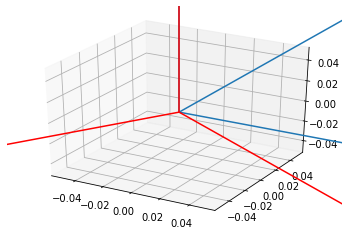

In [71]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



origin = [0,0,0]
X_, Y_, Z_ = zip(origin,origin,origin)
X0_,Y0_,Z0_ = zip(origin,origin,origin)
U, V, W = zip(X,Y,Z)
U0,V0,W0 = zip(x0,y0,z0)

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.quiver(X0_,Y0_,Z0_,U0,V0,W0,arrow_length_ratio=0.01)
ax.quiver(X_,Y_,Z_,U,V,W,arrow_length_ratio=0.01,color='r')
plt.show()

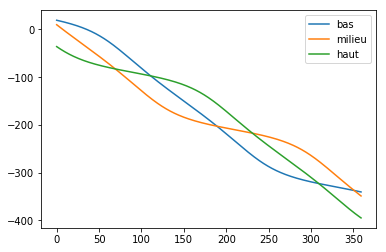

In [17]:
from matplotlib import pyplot as plt
locus = [0,0.7,1]

beta = []
for i in range(360):
    beta.append(i)

bas = []
milieu = []
haut = []

for _ in beta:

    Q=Q_angles(locus,-_)
    haut.append(Q[0])
    milieu.append(Q[1])
    bas.append(Q[2])
    
plt.plot(beta,bas, label='bas')
plt.plot(beta,milieu, label='milieu')
plt.plot(beta,haut, label='haut')
plt.legend()